## RCNN Implementation  Attempt - FAILURE

Due to all efforts being unfruitful with faster RCNN, and not to mention, a bit of an overkill for the project, we moved backwards to RCNN. This notebook has been left uncommented due to it's lack of use, but has been provided to show how RCNN was implemented by first understanding faster-rcnn, through hands on experience.

In [10]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from urllib import request
from tensorflow.keras import initializers

In [15]:
import torch
import torchvision
dummy_img = torch.zeros((1, 3, 800, 800)).float()
print(dummy_img)
dummy_img.shape

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])


torch.Size([1, 3, 800, 800])

In [16]:
model = torchvision.models.vgg16(pretrained=True)
fe = list(model.features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\alexa/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [19]:
req_features = []
k = dummy_img.clone()
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features)) #30
print(out_channels) # 512

30
512


In [21]:
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

NameError: name 'nn' is not defined

In [168]:
backbone = Model(inputs= [vgg.layers[0].input], outputs= [vgg.layers[17].output])
backbone.predict(img_).shape

(1, 50, 50, 512)

In [169]:
backbone.summary()

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0  

In [170]:
# examining the shape of feature map
feature_maps = backbone.predict(np.expand_dims(img, 0))
_, w_feature_map, h_feature_map, _ = feature_maps.shape
# number of posssible anchor positions
n_anchor_pos = w_feature_map * h_feature_map
feature_maps.shape

(1, 50, 50, 512)

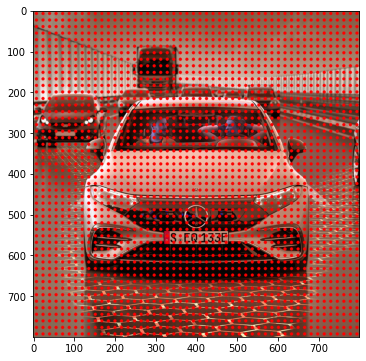

In [171]:
# generating these 2500 centers on the image, placing each of 2500 anchor location with fixed stride to match feature map shape (25*25)
# width stride on the image
width, height = carSize
x_stride = int(width / w_feature_map)
y_stride = int(height / h_feature_map)

# center (xy coordinate) of anchor location on image
x_center = np.arange(8, width, x_stride) # [  0,  32,  64,  96, 128, 160, 192,...]
y_center = np.arange(8, height, y_stride) # [  0,  32,  64,  96, 128, 160, 192,...]

# generate all the ordered pair of x and y center

# to achive this, we will use meshgrid and reshape it
center_list = np.array(np.meshgrid(x_center, y_center,  sparse=False, indexing='xy')).T.reshape(-1,2)

# visualizing the anchor positions
img_ = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(n_anchor_pos):
    cv2.circle(img_, (int(center_list[i][0]), int(center_list[i][1])), radius=1, color=(255, 0, 0), thickness=5) 
plt.imshow(img_)
plt.show()

In [172]:
center_list.shape

(2500, 2)

In [173]:
al = []
# aspect ratio = width/ height
anchor_ratio_list = [0.5, 1, 2] # width is half of height(vertical rectangle), width = height (square), width is twice of height (horizontal rectangle)
anchor_scale_list = [8, 16, 32] # area of each anchor box

# total possible anchors 
n_anchors = n_anchor_pos * len(anchor_ratio_list) * len(anchor_scale_list)


# there are total 2500 anchor centers each having 9 anchor boxes placed
# total anchor box in the feature map will be 2500 * 9 = 22500 each anchor box is denoted by 4 numbers.
anchor_list = np.zeros(shape= (n_anchors, 4))

count = 0
# to get height and width given ratio and scale, we will use formula given above
# for each anchor location
for center in center_list:
    center_x, center_y = center[0], center[1]
    # for each ratio
    for ratio in anchor_ratio_list:
        # for each scale
        for scale in anchor_scale_list:
            # compute height and width and scale them by constant factor
            h = pow(pow(scale, 2)/ ratio, 0.5)
            w = h * ratio

            # as h and w would be really small, we will scale them with some constant (in our case, stride width and height)
            h *= x_stride
            w *= y_stride


            # * at this point we have height and width of anchor and centers of anchor locations
            # putting anchor 9 boxes at each anchor locations
            anchor_xmin = center_x - 0.5 * w
            anchor_ymin = center_y - 0.5 * h
            anchor_xmax = center_x + 0.5 * w
            anchor_ymax = center_y + 0.5 * h
            al.append([center_x, center_y, w, h])
            # append the anchor box to anchor list
            anchor_list[count] = [anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax]
            count += 1

In [174]:
print(anchor_list.shape)
anchor_list

(22500, 4)


array([[ -37.254834  ,  -82.50966799,   53.254834  ,   98.50966799],
       [ -82.50966799, -173.01933598,   98.50966799,  189.01933598],
       [-173.01933598, -354.03867197,  189.01933598,  370.03867197],
       ...,
       [ 701.49033201,  746.745166  ,  882.50966799,  837.254834  ],
       [ 610.98066402,  701.49033201,  973.01933598,  882.50966799],
       [ 429.96132803,  610.98066402, 1154.03867197,  973.01933598]])

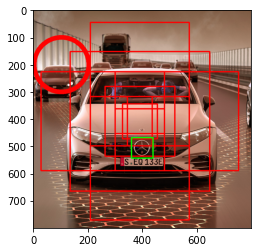

In [175]:
img_ = np.copy(img)
# mid anchor center = 2500/2 = 1250
for i in range(11025, 11034):  # 1250 * 9 = 11025 (9 anchors corresponds to mid anchor center)
    x_min = int(anchor_list[i][0])
    y_min = int(anchor_list[i][1])
    x_max = int(anchor_list[i][2])
    y_max = int(anchor_list[i][3])
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

cv2.rectangle(img_, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=3)
    
cv2.circle(img_, (int(center_list[312][0]), int(center_list[312][1])), radius=100, color=(255, 0, 0), thickness=15) 

plt.imshow(img_)
plt.show()

In [176]:
labels = np.asarray([0, 1], dtype=np.int8)

In [177]:
h = w = 800
# select anchor boxes which are inside the image
inside_anchor_idx_list = np.where(
    (anchor_list[:,0] >= 0) &
    (anchor_list[:,1] >= 0) &
    (anchor_list[:,2] <= w) &
    (anchor_list[:,3] <= h))[0]
print(inside_anchor_idx_list.shape)
inside_anchor_list = anchor_list[inside_anchor_idx_list]
n_inside_anchor = len(inside_anchor_idx_list)

(8940,)


In [178]:
label = np.empty((len(inside_anchor_idx_list), ), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [179]:
valid_anchor_boxes = anchor_list[inside_anchor_idx_list]
print(inside_anchor_list.shape)

(8940, 4)


In [180]:
def IOU(box1, box2):
    """
    Compute overlap (IOU) between box1 and box2
    """
    
    # ------calculate coordinate of overlapping region------
    # take max of x1 and y1 out of both boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    
    # take min of x2 and y2 out of both boxes
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # check if they atleast overlap a little
    if (x1 < x2 and y1 < y2):
        # ------area of overlapping region------
        width_overlap = (x2 - x1)
        height_overlap = (y2 - y1)
        area_overlap = width_overlap * height_overlap
    else:
        # there is no overlap
        return 0
    
    # ------computing union------
    # sum of area of both the boxes - area_overlap
    
    # height and width of both boxes
    width_box1 = (box1[2] - box1[0])
    height_box1 = (box1[3] - box1[1])
    
    width_box2 = (box2[2] - box2[0])
    height_box2 = (box2[3] - box2[1])
    
    # area of box1 and box2
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    
    # union (including 2 * overlap area (double count))
    area_union_overlap = area_box1 + area_box2
    
    # union
    area_union = area_union_overlap - area_overlap
    
    # compute IOU
    iou = area_overlap/ area_union
    
    return iou

In [182]:
iou_list = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
for anchor_idx, anchor_box in enumerate(valid_anchor_boxes):
        # compute IOU
        iou_list[anchor_idx][gt_idx] = IOU(bndbox_img, anchor_box)
iou_list.shape

(8940, 2)

In [184]:
gt_argmax_ious = iou_list.argmax(axis=0)
print(gt_argmax_ious)
gt_max_ious = iou_list[gt_argmax_ious, np.arange(iou_list.shape[1])]
print(gt_max_ious)
# Out:
# [2262 5620]
# [0.68130493 0.61035156]

[3848  790]
[0.3616333       nan]


In [190]:
argmax_ious = iou_list.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = iou_list[np.arange(len(inside_anchor_idx_list)), argmax_ious]
print(max_ious)

(8940,)
[1 1 0 ... 1 1 1]
[1.0299544e-42 1.0299544e-42 0.0000000e+00 ... 4.1484375e+00 4.1640625e+00
 4.1796875e+00]


In [191]:
gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[5866 5874 5882 5890 6102 6109 6112 6117 6120 6125 6128 6133 6136 6141
 6358 6366 6374 6382]


In [192]:
pos_iou_threshold  = 0.7
neg_iou_threshold = 0.3

In [194]:
label[max_ious < neg_iou_threshold] = 0

In [195]:
label[gt_argmax_ious] = 1

In [196]:
label[max_ious >= pos_iou_threshold] = 1

In [197]:
pos_ratio = 0.5
n_sample = 256
n_pos = pos_ratio * n_sample

In [205]:
pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - int(n_pos)), replace=False)
    label[disable_index] = -1

In [206]:
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - int(n_neg)), replace = False)
    label[disable_index] = -1

In [214]:
argmax_ious.shape

(8940,)

In [220]:
argmax_ious = ious.argmax(axis=1).astype(int)
print(argmax_ious.shape)
print(argmax_ious)
gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

(8940,)
[0 0 0 ... 0 0 0]
[5866 5874 5882 5890 6102 6109 6112 6117 6120 6125 6128 6133 6136 6141
 6358 6366 6374 6382]


In [223]:
argmax_ious = np.array(argmax_ious).astype(int)
bndbox_img = np.array(bndbox_img).astype(int)
max_iou_bbox = bndbox_img[argmax_ious]
print(max_iou_bbox)

[361 361 361 ... 361 361 361]


In [228]:
height = valid_anchor_boxes[3] - valid_anchor_boxes[1]
width = valid_anchor_boxes[2] - valid_anchor_boxes[0]
ctr_y = valid_anchor_boxes[1] + 0.5 * height
ctr_x = valid_anchor_boxes[0] + 0.5 * width
base_height = max_iou_bbox[3] - max_iou_bbox[0]
base_width = max_iou_bbox[2] - max_iou_bbox[1]
base_ctr_y = max_iou_bbox[1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[0] + 0.5 * base_width

In [229]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs)

[[1.57740754e+18 1.57740754e+18           -inf           -inf]
 [9.85967712e+00 1.03596771e+01           -inf           -inf]
 [1.16978823e+18 1.16978823e+18           -inf           -inf]
 [4.20282288e+00 4.70282288e+00           -inf           -inf]]


C:\Users\alexa\AppData\Local\Temp/ipykernel_8280/4052958258.py:6: RuntimeWarning: divide by zero encountered in log
  dh = np.log(base_height / height)
C:\Users\alexa\AppData\Local\Temp/ipykernel_8280/4052958258.py:7: RuntimeWarning: divide by zero encountered in log
  dw = np.log(base_width / width)


In [233]:
anchor_labels = np.empty((len(anchor_list),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[inside_anchor_idx_list] = label

In [236]:
anchor_locations = np.empty((len(anchor_list),) + anchor_list.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[inside_anchor_idx_list, :] = anchor_locs

ValueError: shape mismatch: value array of shape (4,4) could not be broadcast to indexing result of shape (8940,4)

In [71]:
n_object = 1
iou_list = np.zeros((n_inside_anchor, 1))
# for each ground truth box
for gt_idx, gt_box in enumerate([bndbox_img,]):
    # for each anchor boxes
    for anchor_idx, anchor_box in enumerate(inside_anchor_list):
        # compute IOU
        iou_list[anchor_idx][gt_idx] = IOU(gt_box, anchor_box)
# convert to dataframe

# add anchor_id
data = {"anchor_id" :inside_anchor_idx_list}

# add object column and corresponding IOU
data.update({f"object_{idx}_iou":iou_list[:, idx] for idx in range(n_object)})

# for each anchor box assign max IOU among all objects in the image
data["max_iou"] = iou_list.max(axis= 1)

# for each anchorbox assign ground truth having maximum IOU
data["best_gt"] = iou_list.argmax(axis= 1)

df_iou = pd.DataFrame(data)

In [72]:
df_iou

,anchor_id,object_0_iou,max_iou,best_gt
0,1404,0.0,0.0,0
1,1413,0.0,0.0,0
2,1422,0.0,0.0,0
3,1431,0.0,0.0,0
4,1440,0.0,0.0,0
...,...,...,...,...
8935,21051,0.0,0.0,0
8936,21060,0.0,0.0,0
8937,21069,0.0,0.0,0
8938,21078,0.0,0.0,0


In [73]:
# getting anchor boxes having maximum IOU for each ground truth boxes
best_ious = df_iou.drop(["anchor_id", "max_iou", "best_gt"],axis= 1).max().values
print(f"Top IOUs for each object in the image: {best_ious}")

# getting anchor box idx having maximum overlap with ground truth boxes * ignoring anchor id column
best_anchors = df_iou.drop(["anchor_id", "max_iou", "best_gt"],axis= 1).values.argmax(axis= 0)
print(f"Top anchor boxes index: {best_anchors}")

# get all the anchor boxes having same IOU score
top_anchors = np.where(iou_list == best_ious)[0]
print(f"Anchor boxes with same IOU score: {top_anchors}")

Top IOUs for each object in the image: [0.3616333]
Top anchor boxes index: [4103]
Anchor boxes with same IOU score: [4103 4111 4119 4377 4385 4393 4651 4659 4667 4925 4933 4941]


4103
4111
4119
4377
4385
4393
4651
4659
4667
4925
4933
4941


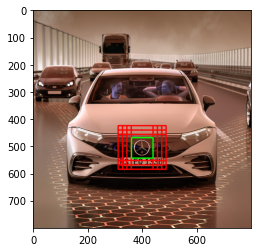

In [76]:
img_ = np.copy(img)
for i in top_anchors:  # 5625// 2
    x_min = int(inside_anchor_list[i][0])
    y_min = int(inside_anchor_list[i][1])
    x_max = int(inside_anchor_list[i][2])
    y_max = int(inside_anchor_list[i][3])
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3)


cv2.rectangle(img_, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=3)

plt.imshow(img_)
plt.show()